<a href="https://colab.research.google.com/github/nahumsa/hackovid19/blob/master/Hackovid19_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Segmentação para imagens de Ressonância

In [0]:
import numpy as np
import os
import nibabel as nib
import pandas as pd
from google.colab import drive
import matplotlib.pyplot as plt
 
# Set numpy to print only 2 decimal digits for neatness
np.set_printoptions(precision=2, suppress=True)

## Dados

Você deve baixar os dados [desse site](https://drive.google.com/file/d/1SJoMelgRqb0EuqlTuq6dxBWf2j9Kno8S/view) e dar upload no colab.

In [2]:
# !git clone https://github.com/nahumsa/hackovid19
# %cd hackovid19

drive.mount('/content/drive/')
%cd '/content/drive/My Drive/hackathon'
%ls

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/
/content/drive/My Drive/hackathon
best_model.hdf5        model.png                         tr_mask.nii.gz
fewshot-segmentation/  Test-Images-Clinical-Details.csv  val_im.nii.gz
logs/                  tr_im.nii.gz


In [0]:
#Pegando as imagens do arquivo
img_train = os.path.join('tr_im.nii.gz')
img_train = nib.load(img_train)

mask_train = os.path.join('tr_mask.nii.gz')
mask_train = nib.load(mask_train) 

img_val = os.path.join('val_im.nii.gz')
img_val = nib.load(img_val)

# Converte para np.array
img_train = img_train.get_fdata() 
mask_train = mask_train.get_fdata()
img_val = img_val.get_fdata()

Pré Processamento


In [0]:
def normalize_function(img, n_obj):

  imag = img.reshape(n_obj, 512, 512)
  maximo = np.max(img)
  minimo = np.min(img)
  delta = (maximo - minimo)  
  imag = (imag - minimo)/delta
  
  return imag

In [6]:
# Faz reshape
img_train = np.moveaxis(img_train,-1, 0)
img_val = np.moveaxis(img_val,-1, 0)
mask_train = np.moveaxis(mask_train,-1,0)

#Normaliza as entradas
img_train = normalize_function(img_train, 100)
img_val = normalize_function(img_val, 10)
# mask_train = normalize_function(mask_train, 100)
 
#Adiciona uma dimensao representando o canal
img_train  = np.expand_dims(img_train, -1).astype('float32')
print(f"Shape do treino: {img_train.shape}")
img_val = np.expand_dims(img_val, -1).astype('float32')
print(f"Shape da validação: {img_val.shape}")
#mask_train = np.expand_dims(mask_train, -1).astype('float32')
print(f"Shape da máscara: {mask_train.shape}")

Shape do treino: (100, 512, 512, 1)
Shape da validação: (10, 512, 512, 1)
Shape da máscara: (100, 512, 512)


Para aumentar a quantidade de imagens farei a agumentação com rotações de 180 no eixo X e Y.

In [0]:
img_train = np.append(img_train, [np.flipud(x) for x in img_train], axis=0)
img_train = np.append(img_train, [np.flip(x,axis = (0,1)) for x in img_train], axis=0)
mask_train = np.append(mask_train, [np.flipud(x) for x in mask_train], axis=0)
mask_train = np.append(mask_train, [np.flip(x,axis = (0,1)) for x in mask_train], axis=0)
print(f"Shape do treino: {img_train.shape}")
print(f"Shape da máscara: {mask_train.shape}")

Separando as classes das máscaras e juntando em apenas 1 array. As classes são:

    1 = ground class opacification
    2 = consolidations 
    3 = pleural effusions.

In [35]:
mask1 = np.where(mask_train == 1, 1., 0.)
mask2 = np.where(mask_train == 2, 1., 0.)
mask3 = np.where(mask_train == 3, 1., 0.)
masks_stack = np.stack((mask1,mask2,mask3), axis=-1)
masks_stack.shape

(400, 512, 512, 3)

 Vamos visualizar alguns exemplos

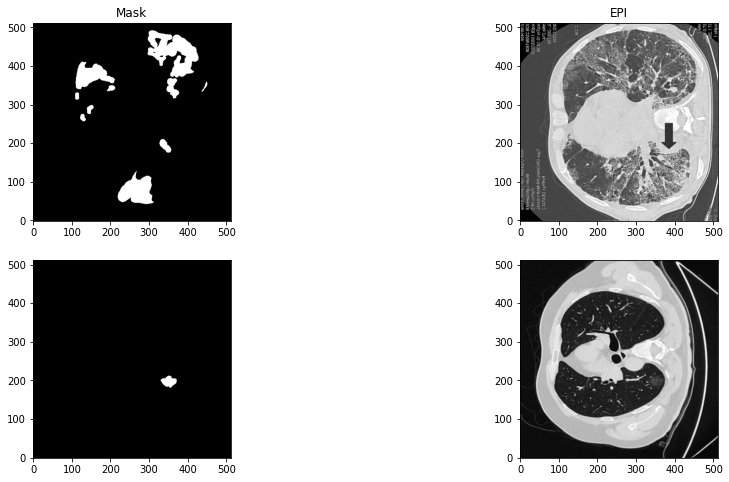

In [37]:
img_index = 101
fig = plt.figure(figsize=(16,8))
gs = fig.add_gridspec(2, 2)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[1, 0])
ax4 = fig.add_subplot(gs[1, 1])


ax1.imshow(masks_stack[img_index,:,:,0], cmap="gray", origin="center")
ax1.set_title('Mask')
ax2.imshow(img_train[img_index,:,:,0], cmap="gray", origin="center")
ax2.set_title('EPI')

ax3.imshow(masks_stack[img_index+ 1,:,:,0], cmap="gray", origin="center")
ax4.imshow(img_train[img_index+ 1,:,:,0], cmap="gray", origin="center")

plt.show()

## Modelo


Para esse exemplo, utilizaremos o modelo UNET, pois é conhecido por ser bom para problemas de segmentação de imagens.

In [0]:
import tensorflow as tf
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from tensorflow.keras.layers import Lambda, RepeatVector, Reshape
from tensorflow.keras.layers import Conv2D, Conv2DTranspose
from tensorflow.keras.layers import MaxPooling2D, GlobalMaxPool2D, UpSampling2D
from tensorflow.keras.layers import concatenate, add
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

#### Losses

In [0]:
from tensorflow.keras import backend as K

def dice_coef(y_true, y_pred, smooth=1):
  intersection = K.sum(y_true * y_pred, axis=[1,2,3])
  union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3])
  dice = K.mean((2. * intersection + smooth)/(union + smooth), axis=0)
  return dice

def dice_loss(y_true, y_pred):
  return 1 - dice_coef(y_true, y_pred)

def iou_coef(y_true, y_pred, smooth=1):
  intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
  union = K.sum(y_true,[1,2,3])+K.sum(y_pred,[1,2,3])-intersection
  iou = K.mean((intersection + smooth) / (union + smooth), axis=0)
  return iou

def jaccard_distance_loss(y_true, y_pred, smooth=100):
    """
    Jaccard = (|X & Y|)/ (|X|+ |Y| - |X & Y|)
            = sum(|A*B|)/(sum(|A|)+sum(|B|)-sum(|A*B|))
    
    The jaccard distance loss is usefull for unbalanced datasets. This has been
    shifted so it converges on 0 and is smoothed to avoid exploding or disapearing
    gradient.
    
    Ref: https://en.wikipedia.org/wiki/Jaccard_index
    
    @url: https://gist.github.com/wassname/f1452b748efcbeb4cb9b1d059dce6f96
    @author: wassname
    """
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    sum_ = K.sum(K.abs(y_true) + K.abs(y_pred), axis=-1)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return (1 - jac) * smooth

In [0]:
def conv2d_block(input_tensor, n_filters, momentum=0.9, kernel_size=3, batchnorm=True):
    # first layer
    x = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size), kernel_initializer="he_normal",
               padding="same")(input_tensor)
    if batchnorm:
        x = BatchNormalization(momentum=momentum)(x)
    x = Activation("relu")(x)
    # second layer
    x = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size), kernel_initializer="he_normal",
               padding="same")(x)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation("relu")(x)
    return x
    
def get_unet(input_img, output_filters=1, n_filters = 16, dropout = 0.1, moment=0.9, batchnorm = True):
  # Contracting Path
  c1 = conv2d_block(input_img, n_filters * 1, momentum=moment, kernel_size = 3, batchnorm = batchnorm)
  p1 = MaxPooling2D((2, 2))(c1)
  p1 = Dropout(dropout)(p1)

  c2 = conv2d_block(p1, n_filters * 2, kernel_size = 3, momentum=moment, batchnorm = batchnorm)
  p2 = MaxPooling2D((2, 2))(c2)
  p2 = Dropout(dropout)(p2)

  c3 = conv2d_block(p2, n_filters * 4, kernel_size = 3, momentum=moment , batchnorm = batchnorm)
  p3 = MaxPooling2D((2, 2))(c3)
  p3 = Dropout(dropout)(p3)

  c4 = conv2d_block(p3, n_filters * 8, kernel_size = 3, momentum=moment , batchnorm = batchnorm)
  p4 = MaxPooling2D((2, 2))(c4)
  p4 = Dropout(dropout)(p4)

  c5 = conv2d_block(p4, n_filters = n_filters * 16, kernel_size = 3, momentum=moment , batchnorm = batchnorm)

  # Expansive Path
  u6 = Conv2DTranspose(n_filters * 8, (3, 3), strides = (2, 2), padding = 'same')(c5)
  u6 = concatenate([u6, c4])
  u6 = Dropout(dropout)(u6)
  c6 = conv2d_block(u6, n_filters * 8, kernel_size = 3, momentum=moment ,batchnorm = batchnorm)

  u7 = Conv2DTranspose(n_filters * 4, (3, 3), strides = (2, 2), padding = 'same')(c6)
  u7 = concatenate([u7, c3])
  u7 = Dropout(dropout)(u7)
  c7 = conv2d_block(u7, n_filters * 4, kernel_size = 3, momentum=moment , batchnorm = batchnorm)

  u8 = Conv2DTranspose(n_filters * 2, (3, 3), strides = (2, 2), padding = 'same')(c7)
  u8 = concatenate([u8, c2])
  u8 = Dropout(dropout)(u8)
  c8 = conv2d_block(u8, n_filters * 2, kernel_size = 3, momentum=moment , batchnorm = batchnorm)

  u9 = Conv2DTranspose(n_filters * 1, (3, 3), strides = (2, 2), padding = 'same')(c8)
  u9 = concatenate([u9, c1])
  u9 = Dropout(dropout)(u9)
  c9 = conv2d_block(u9, n_filters * 1, kernel_size = 3, momentum=moment , batchnorm = batchnorm)

  outputs = Conv2D(output_filters, (1, 1), activation='sigmoid')(c9)
  model = Model(inputs=[input_img], outputs=[outputs])
  return model

In [0]:
input_img = Input((512, 512, 1), name='img')
model = get_unet(input_img, n_filters=16, dropout=0, moment=0.9 ,batchnorm=True)

model.compile(optimizer=Adam(learning_rate=0.0006, decay=0.0002), loss=dice_loss, metrics=["accuracy"])
#tf.keras.utils.plot_model(model, show_shapes=True)

In [0]:
def display(im1,im2,im3):  
  global ims
  fig = plt.figure(figsize=(12,6))
  gs = fig.add_gridspec(1, 1)
  ax1 = fig.add_subplot(gs[0, 0])
  ax1.imshow(im1[0,:,:,0],cmap="gray", origin='center', animated=True)
  ax1.set_title('Predição')
  plt.show()

In [0]:
from IPython.display import clear_output
class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    clear_output(wait=True)
    show_predictions()
    print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

def show_predictions():  
    display(model.predict(img_train),model.predict(img_train), model.predict(img_train))

In [0]:

from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

reduce_LR = ReduceLROnPlateau(monitor='val_loss', 
                              factor=0.1, 
                              patience=5, 
                              verbose=1, 
                              mode='auto', 
                              min_delta=0.0001, 
                              cooldown=0, min_lr=0)

early_stopping = EarlyStopping(monitor='val_loss', 
                               min_delta=0.01, 
                               patience=5, 
                               verbose=1, 
                               mode='max', 
                               restore_best_weights=True)

save_model = ModelCheckpoint("best_model.hdf5",
                             monitor='loss',
                             verbose=1,
                             save_best_only=True,
                             mode='auto',
                             save_freq=1)

callbacks= [reduce_LR, save_model, DisplayCallback()]

In [0]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(img_train, np.expand_dims(mask2, axis=-1), 
                                                    test_size=0.2, random_state=42)

BATCH = 16
EPOCAS = 15
ims= []
history = model.fit(X_train, 
          y_train, 
          batch_size=BATCH, 
          validation_data=(X_test, y_test),          
          epochs=EPOCAS,
          callbacks=callbacks,
          verbose=2)

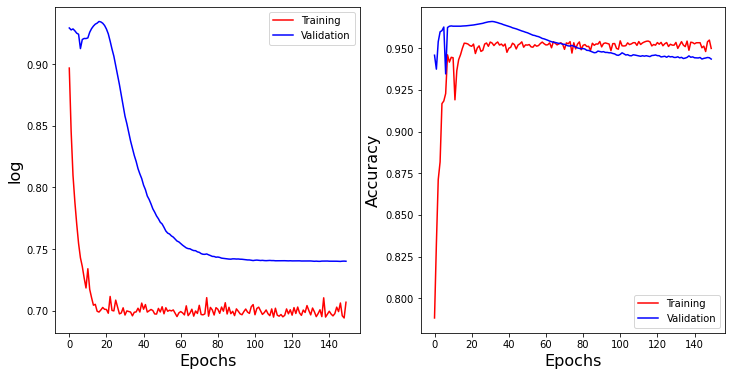

In [31]:
loss = history.history['loss']
val_loss = history.history['val_loss']
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
epochs = range(len(loss))

fig = plt.figure(figsize=(12,6))
gs = fig.add_gridspec(1, 2)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])

ax1.plot(epochs, loss, 'r', label='Training')
ax1.plot(epochs, val_loss, 'b', label='Validation')
ax1.set_xlabel('Epochs', size=16)
ax1.set_ylabel('Loss', size=16)
ax1.set_ylabel('log')
ax1.legend()

ax2.plot(epochs, accuracy, 'r', label='Training')
ax2.plot(epochs, val_accuracy, 'b', label='Validation')
ax2.set_xlabel('Epochs', size=16)
ax2.set_ylabel('Accuracy', size=16)
ax2.legend()
plt.show()

In [0]:
model.load_weights("best_model.hdf5")
print("Loaded weights from disk")

Loaded weights from disk


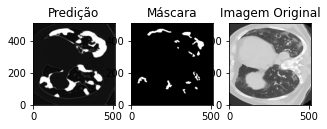

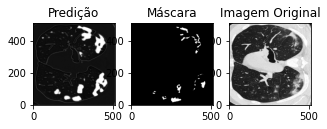

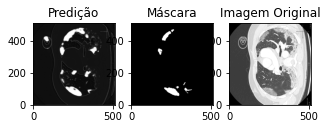

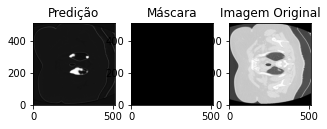

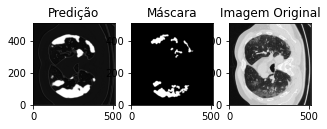

In [32]:
#plot dados 

val = model.predict(X_test[:10])

for i in range(5):
  n_image = np.random.randint(0,len(val))
  fig = plt.figure(figsize=(12,6))
  gs = fig.add_gridspec(1, 7)
  ax1 = fig.add_subplot(gs[0, 0])
  ax2 = fig.add_subplot(gs[0, 1])
  ax3 = fig.add_subplot(gs[0, 2])
    
  ax1.imshow(val[n_image,:,:,0],cmap="gray", origin='center')
  ax1.set_title('Predição')
  ax2.imshow(y_test[n_image,:,:,0], cmap="gray", origin="center")
  ax2.set_title('Máscara')
  ax3.imshow(X_test[n_image,:,:,0], cmap="gray", origin="center")
  ax3.set_title('Imagem Original')
  plt.show()
